In [28]:
import pandas as pd
import numpy as np
import pymysql
import getpass
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_rows", 500)
%matplotlib inline
sns.set()
sns.set_style("ticks")

In [2]:
pw = getpass.getpass()

········


In [3]:
conn = pymysql.connect(host="localhost",
                       port=3306,
                       user="ironhack",
                       passwd=pw,
                       db="olist");

# Analyzing black friday 2017

Black Friday happened on Nov. 24th, 2017.
We are tasked to evaluate the success.

In [4]:
# 0.1
weekly_rev_query = """
SELECT
    DATE_SUB(DATE(o.order_purchase_timestamp), INTERVAL DAYOFWEEK(DATE(o.order_purchase_timestamp)) - 1 DAY) AS week_id,
    SUM(oi.price) AS revenue_generated
FROM order_items oi
    JOIN orders o
    ON oi.order_id = o.order_id
WHERE o.order_purchase_timestamp < '2018-01-15'
    AND o.order_purchase_timestamp > '2017-03-05'
GROUP BY 1
ORDER BY 1;
"""

weekly_revenue = pd.read_sql(weekly_rev_query, conn)

In [5]:
# 0.2
weekly_revenue.head()

,week_id,revenue_generated
0,2017-03-05,78704.619772
1,2017-03-12,95487.199723
2,2017-03-19,85260.389904
3,2017-03-26,83634.099916
4,2017-04-02,94745.860022


In [6]:
# 0.3
weekly_revenue.dtypes

week_id               object
revenue_generated    float64
dtype: object

In [8]:
# 0.4
weekly_revenue["week_id"] = pd.to_datetime(weekly_revenue["week_id"])

In [10]:
# 0.5
weekly_revenue = weekly_revenue.set_index("week_id")

## Approach 1:
Week over week comparison

In [11]:
# 1.1
week_comp = weekly_revenue.copy()

In [13]:
# 1.2
# Filter df for only the black friday week and the week prior
black_friday_week = "2017-11-19"
prior_week = "2017-11-12"
week_comp = week_comp.loc[prior_week:black_friday_week]

In [21]:
week_comp

,revenue_generated
week_id,
2017-11-12,178951.390068
2017-11-19,381809.340397


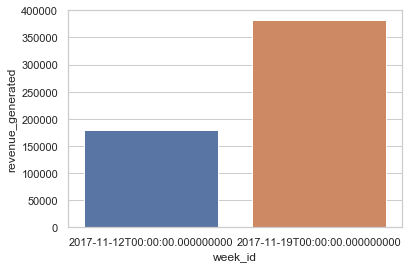

In [15]:
# 1.3 plot bars
sns.barplot(data=week_comp,
            x=week_comp.index,
            y="revenue_generated");

In [25]:
# 1.4 compute diffs
abs_diff_week_comp = week_comp.loc["2017-11-19", "revenue_generated"] - week_comp.loc["2017-11-12", "revenue_generated"]
rel_diff_week_comp = (week_comp.loc["2017-11-19", "revenue_generated"] / week_comp.loc["2017-11-12", "revenue_generated"]) - 1

print(f"""The revenue for the week of black friday increased by {round(rel_diff_week_comp * 100)}% compared to the week prior.
This represents an increase of revenue by {round(abs_diff_week_comp)} Reais.
""")

The revenue for the week of black friday increased by 113.0% compared to the week prior.
This represents an increase of revenue by 202858.0 Reais.



---

## Approach 2:
Accounting for the weeks after black friday

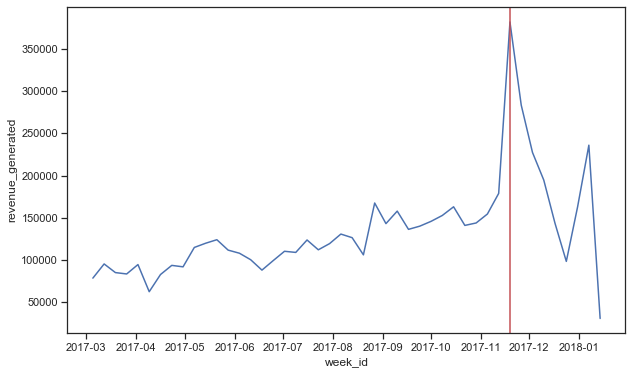

In [32]:
# 2.1 plot weekly_rev
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=weekly_revenue,
             x=weekly_revenue.index,
             y="revenue_generated",
             ax=ax);

ax.axvline("2017-11-19", color="r");

In [34]:
# 2.2
week_hangover = (weekly_revenue
                 .copy()
                 .loc["2017-11-12":"2017-12-31"])
week_hangover

,revenue_generated
week_id,
2017-11-12,178951.390068
2017-11-19,381809.340397
2017-11-26,283473.019732
2017-12-03,227372.830050
2017-12-10,194720.879677
2017-12-17,143431.610006
2017-12-24,98513.040154
2017-12-31,163005.200357


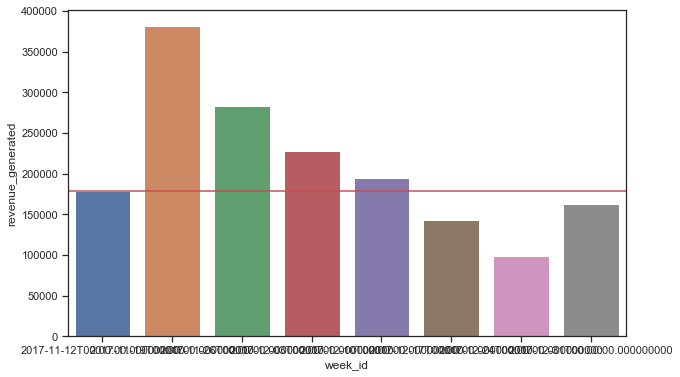

In [38]:
# 2.3
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=week_hangover,
            x=week_hangover.index,
            y="revenue_generated",
            ax=ax);
ax.axhline(week_hangover.loc["2017-11-12", "revenue_generated"], color="r");

In [39]:
# 2.4
rev_reference_week = week_hangover.loc["2017-11-12", "revenue_generated"]
rev_subsequent_weeks = week_hangover.loc["2017-11-19":, "revenue_generated"]

In [45]:
# 2.5
rev_predictions = rev_subsequent_weeks.to_frame().assign(predicted_revenue=rev_reference_week)

In [56]:
# 2.6 Estimate black friday impact
abs_diff_hangover = (rev_predictions["revenue_generated"] - rev_predictions["predicted_revenue"]).sum()
rel_diff_hangover = abs_diff_hangover / rev_reference_week

print(f"""The revenue increased by {round(rel_diff_hangover * 100)}% due to black friday compared to the our forecasts.
This represents an increase of revenue by {round(abs_diff_hangover)} Reais.
""")

The revenue increased by 134.0% due to black friday compared to the our forecasts.
This represents an increase of revenue by 239666.0 Reais.



## Lab
Extend approach 2 to account for consumers that postponed purchases to the black friday week that otherwise would have purchased prior to black friday.
You can use a simple weeks revenue as a forecast for simplicity. Just make sure to set somewhat reasonable boundaries for the date range affected by black friday. 